# Excess Variance analysis for the sources on 4LAC Catalog

In this notebook, you will find:

1) The computed **_Normalized Excess Variance_** ($\sigma _{NXS}^{2} = F_{var}^{2}$ found in [Vaughan et. al 2003](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.345.1271V)), for each source from the catalog, and also for each Synchrotron Class.


2) New plots:

* Fvar² vs Flux (per source class)
* Histograms of Fvar² per class, to test if they are consistent
* Flux vs index of sources with high Fvar². In order to prove that the assumptions we make below 10 GeV (softer when brighter) is true/consistent with LAT data.


In order to do that, I've created a function to compute the Excess Variance, and you can find the analysis below, in the analysis we compare each source's _Normalized Excess Variance_ with its average flux from the spectrum, which we called _Average Spectrum Flux_.

In [1]:
## CHANGE PATH IN: __init__.ipynb

%run __init__.ipynb

When you run __init__.ipynb, you upload the imports, as well as the paths, functions and dataframes necessary for the analysis.

################### IMPORTANT PATHS ###################

--> PATH : for the main folder CTA_BrighteningAnalysis downloaded from Github

For the downloaded lightcurves from the catalog folder, use:
-> PATH_3DAY_LC : 3-day bin lightcurves
-> PATH_WEEKLY_LC : weekly bin lightcurves

##################### DATAFRAMES ######################

# of sources in the dataframes:
dfLSP: 1538
dfISP: 508
dfHSP: 548
---> total: 2594

dat: 3511

############### LIGHTCURVES FROM FOLDER ###############

--------------- 3-day bin ---------------

# of lightcurves from the folder in the array:
lc_downloaded_LSP_3days: 465
lc_downloaded_ISP_3days: 60
lc_downloaded_HSP_3days: 66
---> total: 591

lc_downloaded_3days: 683

--------------- Weekly bin ---------------

# of lightcurves from the folder in the array:
lc_downloaded_LSP_weekly: 465
lc_downloaded_ISP_weekly: 60
lc_downloaded

## $\sigma _{NXS}^{2}$: The Excess Variance (or Normalized Excess Variance)

- $\sigma _{NXS}^{2}$ is calculated by Equation 8 from [Vaughan et. al 2003](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.345.1271V).

$$ \sigma _{NXS}^{2} = \frac{ S^{2} - \overline{\sigma_{err}^{2}} }{ \overline{x}^{2}} = F_{var}^{2} $$


- The uncertainty of $F_{var}^{2}$ (Normalized Excess Variance) is calculated by Equation 11 of [Vaughan et. al 2003](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.345.1271V):

The error on $\sigma _{NXS}^{2}$ decreases as the signal-to-noise (S/N) ratio in the light curve is increased according to

$$ err(\sigma _{NXS}^{2}) = \sqrt{\left (\sqrt{ \frac{2}{N}} \ \cdot \frac{ \overline{\sigma_{err}^{2}} }{ \overline{x}^{2} } \right )^{2} + \left ( \sqrt{\frac{\overline{\sigma_{err}^{2}}}{N}} \ \cdot \frac{2 F_{var}}{\overline{x}} \right )^{2} \ } $$



## $F_{var}$: The Fractional Variability Parameter (or Amplitude)

- $F_{var}$ is calculated by Equation 10 from [Vaughan et. al 2003](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.345.1271V). It is also used in [Acciari et. al 2020](https://arxiv.org/pdf/2001.08678.pdf).

$$ F_{var} = \sqrt{ \frac{ S^{2} - \overline{\sigma_{err}^{2}}}{ \overline{x}^{2} } } $$

- The uncertainty of $F_{var}$ is calculated by Equation B2 from [Vaughan et. al 2003](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.345.1271V):

$$ err(F_{var}) = \sqrt{ \left ( \sqrt{\frac{1}{2N}} \ \cdot \frac{\overline{\sigma_{err}^{2}}}{\overline{x}^{2} \ F_{var}}  \right )^{2} + \left ( \sqrt{\frac{\overline{\sigma_{err}^{2}}}{N}} \ \cdot \frac{1}{\overline{x}}  \right )^{2} \ } $$


$ \overline{x} $ ( or $ < F_{\gamma } > $): average photon flux

$ S $: the standard deviation of the N flux measurements

$ \overline{\sigma_{err}^{2}} $: the mean squared error

$ N $: number N of flux measurements

All determined for a given instrument and energy band.

## Creating a function

In [47]:
from sklearn.metrics import mean_squared_error


## ---------- Normalized Excess Variance ----------
def compute_excessvariance(flux, flux_low_error, flux_high_error, flux_upper_lim):
    ########## Description ##########
    # ---------- Input ----------
    # flux            : name of .json file             (string)
    # flux_low_error  : low error of the flux value    (1D-array)
    # flux_high_error : high error of the flux value   (1D-array)
    # flux_upper_lim  : the flux values of the UL      (1D-array)
    # ---------- Output ----------
    # excess_variance       : normalized excess variance of the source    (float)
    # excess_variance_error : error of the excess variance                (float)
    #################################
    
    ## Creating masks
    mask_high_larger_than_low = flux_high_error > flux_low_error    ## mask in which the high errors are larger than the low errors
    mask_low_larger_than_high = flux_low_error > flux_high_error    ## mask in which the low errors are larger than the high errors

    flux_error = np.zeros_like(flux_high_error)

    ## The flux error will be the largest one comparing to high and low errors
    flux_error[mask_high_larger_than_low] = flux_high_error[mask_high_larger_than_low]
    flux_error[mask_low_larger_than_high] = flux_low_error[mask_low_larger_than_high]
    
    N = len(flux)                                ## Number of flux points
    S_std = np.std(flux, ddof=1)                 ## S - standard deviation of the N flux measurements
    mse = ((flux_error)**2).mean(axis=None)      ## Mean Squared Error
    # aver_photon_flux = np.mean(flux)           ## Average Photon Flux
    
    ## instead of using the simple average of the LC photon flux, we will include the Flux_UL = 0, and use the weighted average
    average_photon_flux_withUL = calculate_average_flux_when_fluxUL_is_zero(flux, flux_upper_lim)
    
    
    Fvar = np.sqrt((S_std**2 + mse**2)/ average_photon_flux_withUL**2)
    excess_variance = (S_std**2 + mse**2)/ average_photon_flux_withUL**2
    
    ## Fvar factors
    factor1 = np.sqrt( 1 / (2*N) ) * mse / ( average_photon_flux_withUL**2 * Fvar )
    factor2 = np.sqrt( mse / N ) * ( 1 / average_photon_flux_withUL )
    
    ## Excess variance factors
    factor3 = np.sqrt( 2 / N ) * ( mse / average_photon_flux_withUL**2 )
    factor4 = np.sqrt( mse / N ) * ( (2*Fvar) / average_photon_flux_withUL )
    
    Fvar_error = np.sqrt( (factor1)**2 + (factor2)**2 )
    excess_variance_error = np.sqrt( (factor3)**2 + (factor4)**2 )
    
    return excess_variance, excess_variance_error

# Fvar² (excess variances) vs. Flux - **per source class**

Remmber that we are using separate arrays for each source type:

--------------- 3-day bin ---------------

- lc_downloaded_LSP_3days
- lc_downloaded_ISP_3days
- lc_downloaded_HSP_3days

--------------- Weekly bin ---------------

- lc_downloaded_LSP_weekly
- lc_downloaded_ISP_weekly
- lc_downloaded_HSP_weekly



We will compute the $F_{var}^{2}$ and its uncertainty for each source, separating by its class.

I have created lists to save in the same sequence the file_names, the excess_variance, its error and the average_spectrum_flux from the spectrum.

## 3-days

Here we are using 3-day bin light curves located in folder '/lightcurve_downloader/downloaded_lightcurves/3day_lightcurves' as we called "PATH_3DAY_LC" in the \_\_init\_\_ file.

The arrays mentioned above contains all the source names.

#### High Synchrotron Peak

In [3]:
## Creating a list with each file name
file_names_HSP_3days = []

## Creating a list with each excess variance and error
excessvariance_HSP_3days = []
error_excessvariance_HSP_3days = []

## Creating a list with each average flux and spectrum flux (for the plots)
# average_LCflux_HSP_3days = []
average_spectrumflux_HSP_3days = []


## Loop to fill the lists
for file in lc_downloaded_HSP_3days:
    
    file_name = file  # .json file name

    json_data = extract_data_from_file('3-days', file_name)
    # ---- Input: bins: 'weekly'/ '3-days', file name
    # ---- Output: name, time, flux, time_error, flux_low_error, flux_high_error, time_upper_lim, flux_upper_lim

    table_params = extract_parameters_from_table(json_data[0], dat, json_data[2])
    # ---- Input: name, dataframe, flux
    # ---- Output: E, dflux, spec_type, integral_flux
    
    excessvariance_with_error = compute_excessvariance(json_data[2], json_data[4], json_data[5], json_data[7])
    # ---- Input: flux, flux_low_error, flux_high_error, flux_upper_lim
    # ---- Output: excessvariance, excessvariance_error
    
    file_names_HSP_3days.append(file_name)
    
    excessvariance_HSP_3days.append(excessvariance_with_error[0])
    error_excessvariance_HSP_3days.append(excessvariance_with_error[1])
    
    # average_LCflux_HSP_3days.append(np.mean(json_data[2]))
    average_spectrumflux_HSP_3days.append(np.mean(table_params[3]))
    

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha)),
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha - beta * np.log(x/E0))),


Uncomment the cell below for each source's excess variance

In [4]:
# print('\n--------------- High Synchrotron Peak (3-day bin) ---------------')

# for i in range(len(lc_downloaded_HSP_3days)):
#     print('excess variance for', file_names_HSP_3days[i], ':', f"{excessvariance_HSP_3days[i]:.2f}", '+/-', f"{error_excessvariance_HSP_3days[i]:.2f}")
    

In [5]:
## Just checking if we have gone through all the files

print(len(excessvariance_HSP_3days))
print(len(lc_downloaded_HSP_3days))
print(len(excessvariance_HSP_3days) == len(lc_downloaded_HSP_3days))

66
66
True


#### Intermediate Synchrotron Peak

In [6]:
## Creating a list with each file name
file_names_ISP_3days = []

## Creating a list with each excess variance and error
excessvariance_ISP_3days = []
error_excessvariance_ISP_3days = []
    
## Creating a list with each average flux and spectrum flux (for the plots)
# average_LCflux_ISP_3days = []
average_spectrumflux_ISP_3days = []
    

## Loop to fill the lists
for file in lc_downloaded_ISP_3days:
    
    file_name = file  # .json file name

    json_data = extract_data_from_file('3-days', file_name)
    # ---- Input: bins: 'weekly'/ '3-days', file name
    # ---- Output: name, time, flux, time_error, flux_low_error, flux_high_error, time_upper_lim, flux_upper_lim

    table_params = extract_parameters_from_table(json_data[0], dat, json_data[2])
    # ---- Input: name, dataframe, flux
    # ---- Output: E, dflux, spec_type, integral_flux
    
    excessvariance_with_error = compute_excessvariance(json_data[2], json_data[4], json_data[5], json_data[7])
    # ---- Input: flux, flux_low_error, flux_high_error, flux_upper_lim
    # ---- Output: excessvariance, excessvariance_error
    
    file_names_ISP_3days.append(file_name)
    
    excessvariance_ISP_3days.append(excessvariance_with_error[0])
    error_excessvariance_ISP_3days.append(excessvariance_with_error[1])
    
    # average_LCflux_ISP_3days.append(np.mean(json_data[2]))
    average_spectrumflux_ISP_3days.append(np.mean(table_params[3]))
    

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha - beta * np.log(x/E0))),
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha)),


Uncomment the cell below for each source's excess variance

In [75]:
print('\n--------------- Intermediate Synchrotron Peak (3-day bin) ---------------')

for i in range(len(lc_downloaded_ISP_3days)):
    print('excess variance for', file_names_ISP_3days[i], ':', f"{excessvariance_ISP_3days[i]:.2f}", '+/-', f"{error_excessvariance_ISP_3days[i]:.2f}")
    


--------------- Intermediate Synchrotron Peak (3-day bin) ---------------
excess variance for 4FGL+J0021.5-2552.json : 28.16 +/- 30.61
excess variance for 4FGL+J0021.9-5140.json : 18231.08 +/- 0.75
excess variance for 4FGL+J0050.7-0929.json : 1.68 +/- 0.84
excess variance for 4FGL+J0056.3-0935.json : 24.24 +/- 27.07
excess variance for 4FGL+J0056.4-2118.json : 17.40 +/- 18.48
excess variance for 4FGL+J0056.6-5317.json : 842.40 +/- 754.71
excess variance for 4FGL+J0111.5-2546.json : 229.75 +/- 583.91
excess variance for 4FGL+J0120.4-2701.json : 1.18 +/- 0.79
excess variance for 4FGL+J0146.0-6746.json : 56.60 +/- 108.83
excess variance for 4FGL+J0158.5-3932.json : 16.74 +/- 27.64
excess variance for 4FGL+J0218.9-2305.json : 50.38 +/- 83.17
excess variance for 4FGL+J0343.2-6444.json : 5223.74 +/- 51.70
excess variance for 4FGL+J0345.2-2353.json : 10.87 +/- 18.56
excess variance for 4FGL+J0409.8-0359.json : 40.10 +/- 84.07
excess variance for 4FGL+J0434.1-2014.json : 61.04 +/- 125.38
exce

In [8]:
## Just checking if we have gone through all the files

print(len(excessvariance_ISP_3days))
print(len(lc_downloaded_ISP_3days))
print(len(excessvariance_ISP_3days) == len(lc_downloaded_ISP_3days))

60
60
True


#### Low Synchrotron Peak

In [9]:
## Creating a list with each file name
file_names_LSP_3days = []

## Creating a list with each excess variance and error
excessvariance_LSP_3days = []
error_excessvariance_LSP_3days = []

## Creating a list with each average flux and spectrum flux (for the plots)
# average_LCflux_LSP_3days = []
average_spectrumflux_LSP_3days = []


## Loop to fill the lists
for file in lc_downloaded_LSP_3days:
    
    file_name = file  # .json file name

    json_data = extract_data_from_file('3-days', file_name)
    # ---- Input: bins: 'weekly'/ '3-days', file name
    # ---- Output: name, time, flux, time_error, flux_low_error, flux_high_error, time_upper_lim, flux_upper_lim

    table_params = extract_parameters_from_table(json_data[0], dat, json_data[2])
    # ---- Input: name, dataframe, flux
    # ---- Output: E, dflux, spec_type, integral_flux
    
    excessvariance_with_error = compute_excessvariance(json_data[2], json_data[4], json_data[5], json_data[7])
    # ---- Input: flux, flux_low_error, flux_high_error, flux_upper_lim
    # ---- Output: excessvariance, excessvariance_error
    
    file_names_LSP_3days.append(file_name)
    
    excessvariance_LSP_3days.append(excessvariance_with_error[0])
    error_excessvariance_LSP_3days.append(excessvariance_with_error[1])
    
    # average_LCflux_LSP_3days.append(np.mean(json_data[2]))
    average_spectrumflux_LSP_3days.append(np.mean(table_params[3]))
    

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha)),
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha - beta * np.log(x/E0))),


Uncomment the cell below for each source's excess variance

In [10]:
# print('\n--------------- Low Synchrotron Peak (3-day bin) ---------------')

# for i in range(len(lc_downloaded_LSP_3days)):
#     print('excess variance for', file_names_LSP_3days[i], ':', f"{excessvariance_LSP_3days[i]:.2f}", '+/-', f"{error_excessvariance_LSP_3days[i]:.2f}")
    

In [11]:
## Just checking if we have gone through all the files

print(len(excessvariance_LSP_3days))
print(len(lc_downloaded_LSP_3days))
print(len(excessvariance_LSP_3days) == len(lc_downloaded_LSP_3days))

465
465
True


## Weekly

Here we are using weekly light curves located in folder '/lightcurve_downloader/downloaded_lightcurves/weekly_lightcurves' as we called "PATH_WEEKLY_LC" in the \_\_init\_\_ file.

The arrays mentioned above contains all the source names.

#### High Synchrotron Peak

In [12]:
## Creating a list with each file name
file_names_HSP_weekly = []

## Creating a list with each excess variance and error
excessvariance_HSP_weekly = []
error_excessvariance_HSP_weekly = []

## Creating a list with each average flux and spectrum flux (for the plots)
# average_LCflux_HSP_weekly = []
average_spectrumflux_HSP_weekly = []


## Loop to fill the lists
for file in lc_downloaded_HSP_weekly:
    
    file_name = file  # .json file name

    json_data = extract_data_from_file('weekly', file_name)
    # ---- Input: bins: 'weekly'/ '3-days', file name
    # ---- Output: name, time, flux, time_error, flux_low_error, flux_high_error, time_upper_lim, flux_upper_lim

    table_params = extract_parameters_from_table(json_data[0], dat, json_data[2])
    # ---- Input: name, dataframe, flux
    # ---- Output: E, dflux, spec_type, integral_flux
    
    excessvariance_with_error = compute_excessvariance(json_data[2], json_data[4], json_data[5], json_data[7])
    # ---- Input: flux, flux_low_error, flux_high_error, flux_upper_lim
    # ---- Output: excessvariance, excessvariance_error
    
    file_names_HSP_weekly.append(file_name)
    
    excessvariance_HSP_weekly.append(excessvariance_with_error[0])
    error_excessvariance_HSP_weekly.append(excessvariance_with_error[1])
    
    # average_LCflux_HSP_weekly.append(np.mean(json_data[2]))
    average_spectrumflux_HSP_weekly.append(np.mean(table_params[3]))
    

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha)),
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha - beta * np.log(x/E0))),


Uncomment the cell below for each source's excess variance

In [13]:
# print('\n--------------- High Synchrotron Peak (Weekly bin) ---------------')

# for i in range(len(lc_downloaded_HSP_weekly)):
#     print('excess variance for', file_names_HSP_weekly[i], ':', f"{excessvariance_HSP_weekly[i]:.2f}", '+/-', f"{error_excessvariance_HSP_weekly[i]:.2f}")


In [14]:
## Just checking if we have gone through all the files

print(len(excessvariance_HSP_weekly))
print(len(lc_downloaded_HSP_weekly))
print(len(excessvariance_HSP_weekly) == len(lc_downloaded_HSP_weekly))

66
66
True


#### Intermediate Synchrotron Peak

In [15]:
## Creating a list with each file name
file_names_ISP_weekly = []

## Creating a list with each excess variance and error
excessvariance_ISP_weekly = []
error_excessvariance_ISP_weekly = []

## Creating a list with each average flux and spectrum flux (for the plots)
# average_LCflux_ISP_weekly = []
average_spectrumflux_ISP_weekly = []


## Loop to fill the lists
for file in lc_downloaded_ISP_weekly:
    
    file_name = file  # .json file name

    json_data = extract_data_from_file('weekly', file_name)
    # ---- Input: bins: 'weekly'/ '3-days', file name
    # ---- Output: name, time, flux, time_error, flux_low_error, flux_high_error, time_upper_lim, flux_upper_lim

    table_params = extract_parameters_from_table(json_data[0], dat, json_data[2])
    # ---- Input: name, dataframe, flux
    # ---- Output: E, dflux, spec_type, integral_flux
    
    excessvariance_with_error = compute_excessvariance(json_data[2], json_data[4], json_data[5], json_data[7])
    # ---- Input: flux, flux_low_error, flux_high_error, flux_upper_lim
    # ---- Output: excessvariance, excessvariance_error
    
    file_names_ISP_weekly.append(file_name)
    
    excessvariance_ISP_weekly.append(excessvariance_with_error[0])
    error_excessvariance_ISP_weekly.append(excessvariance_with_error[1])
    
    # average_LCflux_ISP_weekly.append(np.mean(json_data[2]))
    average_spectrumflux_ISP_weekly.append(np.mean(table_params[3]))

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha - beta * np.log(x/E0))),
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha)),


Uncomment the cell below for each source's excess variance

In [16]:
# print('\n--------------- Intermediate Synchrotron Peak (Weekly bin) ---------------')

# for i in range(len(lc_downloaded_ISP_weekly)):
#     print('excess variance for', file_names_ISP_weekly[i], ':', f"{excessvariance_ISP_weekly[i]:.2f}", '+/-', f"{error_excessvariance_ISP_weekly[i]:.2f}")
    

In [17]:
## Just checking if we have gone through all the files

print(len(excessvariance_ISP_weekly))
print(len(lc_downloaded_ISP_weekly))
print(len(excessvariance_ISP_weekly) == len(lc_downloaded_ISP_weekly))

60
60
True


#### Low Synchrotron Peak

In [18]:
## Creating a list with each file name
file_names_LSP_weekly = []

## Creating a list with each excess variance and error
excessvariance_LSP_weekly = []
error_excessvariance_LSP_weekly = []

## Creating a list with each average flux and spectrum flux (for the plots)
# average_LCflux_LSP_weekly = []
average_spectrumflux_LSP_weekly = []


## Loop to fill the lists
for file in lc_downloaded_LSP_weekly:
    
    file_name = file  # .json file name

    json_data = extract_data_from_file('weekly', file_name)
    # ---- Input: bins: 'weekly'/ '3-days', file name
    # ---- Output: name, time, flux, time_error, flux_low_error, flux_high_error, time_upper_lim, flux_upper_lim

    table_params = extract_parameters_from_table(json_data[0], dat, json_data[2])
    # ---- Input: name, dataframe, flux
    # ---- Output: E, dflux, spec_type, integral_flux
    
    excessvariance_with_error = compute_excessvariance(json_data[2], json_data[4], json_data[5], json_data[7])
    # ---- Input: flux, flux_low_error, flux_high_error, flux_upper_lim
    # ---- Output: excessvariance, excessvariance_error
    
    file_names_LSP_weekly.append(file_name)
    
    excessvariance_LSP_weekly.append(excessvariance_with_error[0])
    error_excessvariance_LSP_weekly.append(excessvariance_with_error[1])
    
    # average_LCflux_LSP_weekly.append(np.mean(json_data[2]))
    average_spectrumflux_LSP_weekly.append(np.mean(table_params[3]))

/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:183: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha)),
/var/folders/sk/6dg2gqpn01x3m5hwkj90qkgw0000gp/T/ipykernel_32046/1516064003.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrateflux = integrate.quad(lambda x: K * ((x/E0)**(-alpha - beta * np.log(x/E0))),


Uncomment the cell below for each source's excess variance

In [19]:
# print('\n--------------- Low Synchrotron Peak (Weekly bin) ---------------')

# for i in range(len(lc_downloaded_LSP_weekly)):
#     print('excess variance for', file_names_LSP_weekly[i], ':', f"{excessvariance_LSP_weekly[i]:.2f}", '+/-', f"{error_excessvariance_LSP_weekly[i]:.2f}")
    

In [20]:
## Just checking if we have gone through all the files

print(len(excessvariance_LSP_weekly))
print(len(lc_downloaded_LSP_weekly))
print(len(excessvariance_LSP_weekly) == len(lc_downloaded_LSP_weekly))

465
465
True


## Analysis per Class

An analysis of the $F_{var}$ as a function of the average flux from the lightcurve and the average spectrum flux, for each synchrotron type.

In [22]:
print('\n--------------- 3-days ---------------')

print('\nMean excess variance for High Sync. Peak sources:', f"{np.mean(excessvariance_HSP_3days):.2f}")
print('Mean excess variance for Intermediate Sync. Peak sources:', f"{np.mean(excessvariance_ISP_3days):.2f}")
print('Mean excess variance for Low Sync. Peak sources:', f"{np.mean(excessvariance_LSP_3days):.2f}")

print('\n--------------- Weekly ---------------')

print('\nMean excess variance for High Sync. Peak sources:', f"{np.mean(excessvariance_HSP_weekly):.2f}")
print('Mean excess variance for Intermediate Sync. Peak sources:', f"{np.mean(excessvariance_ISP_weekly):.2f}")
print('Mean excess variance for Low Sync. Peak sources:', f"{np.mean(excessvariance_LSP_weekly):.2f}")


--------------- 3-days ---------------

Mean excess variance for High Sync. Peak sources: 1285.33
Mean excess variance for Intermediate Sync. Peak sources: 1364.78
Mean excess variance for Low Sync. Peak sources: 1176.90

--------------- Weekly ---------------

Mean excess variance for High Sync. Peak sources: 127.23
Mean excess variance for Intermediate Sync. Peak sources: 366.34
Mean excess variance for Low Sync. Peak sources: 313.47


### Excess Variance vs. Average Spectrum Flux

(Average Spectrum Flux from the Spectrum)

Log in x-axis and y-axis

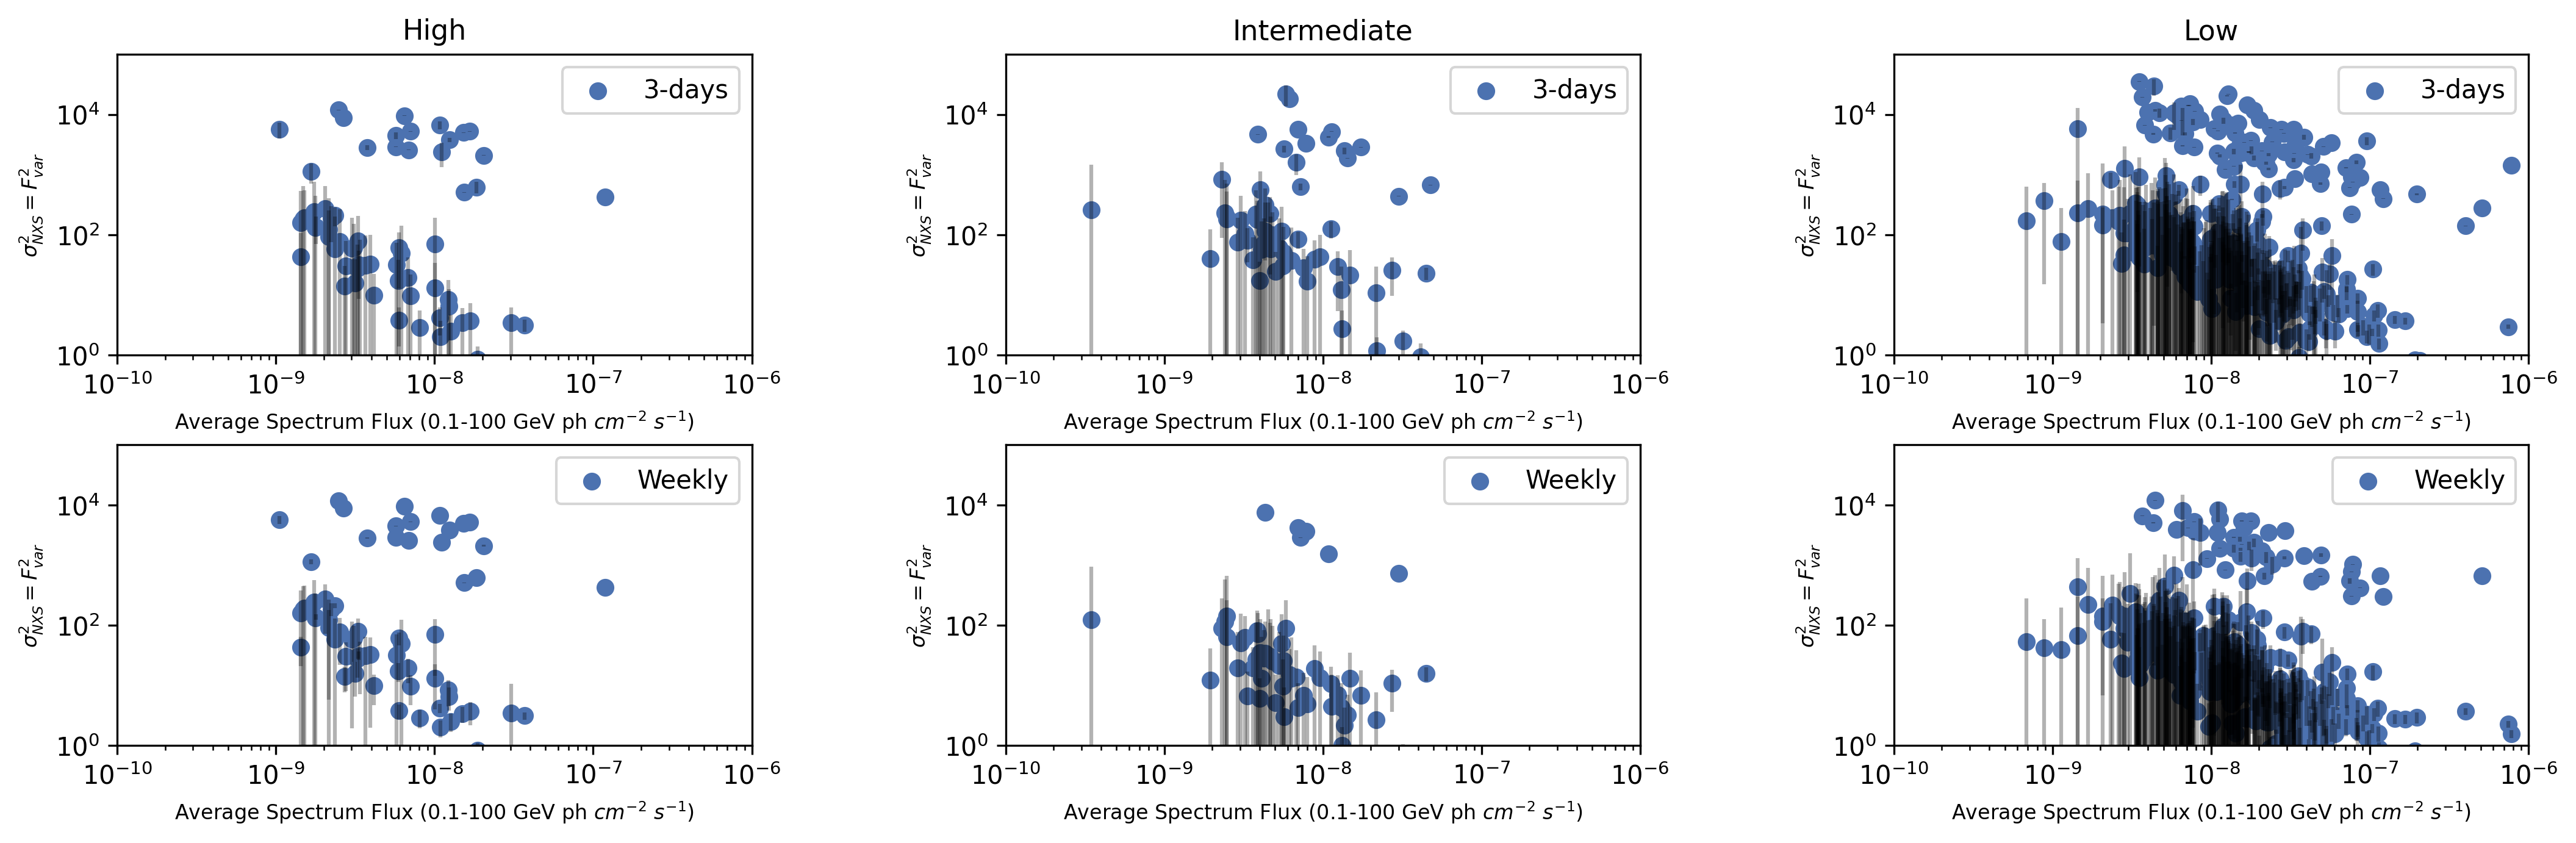

In [72]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.figure(figsize=(17,5), dpi=300)


plt.subplot(grid[0, 0])

plt.scatter(average_spectrumflux_HSP_3days, excessvariance_HSP_3days, label = '3-days')
plt.errorbar(average_spectrumflux_HSP_3days, excessvariance_HSP_3days, 
             yerr = error_excessvariance_HSP_3days, xerr = None, ls='none', ecolor = 'black', alpha = 0.3) 
plt.xlim(1e-10,1e-6)
plt.ylim(1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.title('High', fontsize=11)
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=8)
plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=8)
plt.legend()




plt.subplot(grid[0, 1])

plt.scatter(average_spectrumflux_ISP_3days, excessvariance_ISP_3days, label = '3-days')
plt.errorbar(average_spectrumflux_ISP_3days, excessvariance_ISP_3days, 
             yerr = error_excessvariance_ISP_3days, xerr = None, ls='none', ecolor = 'black', alpha = 0.3)
plt.xlim(1e-10,1e-6)
plt.ylim(1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.title('Intermediate', fontsize=11)
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=8)
plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=8)
plt.legend()




plt.subplot(grid[0, 2])

plt.scatter(average_spectrumflux_LSP_3days, excessvariance_LSP_3days, label = '3-days')
plt.errorbar(average_spectrumflux_LSP_3days, excessvariance_LSP_3days, 
             yerr = error_excessvariance_LSP_3days, xerr = None, ls='none', ecolor = 'black', alpha = 0.3) 
plt.xlim(1e-10,1e-6)
plt.ylim(1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.title('Low', fontsize=11)
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=8)
plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=8)
plt.legend()




plt.subplot(grid[1, 0])

plt.scatter(average_spectrumflux_HSP_weekly, excessvariance_HSP_3days, label = 'Weekly')
plt.errorbar(average_spectrumflux_HSP_weekly, excessvariance_HSP_3days, 
             yerr = error_excessvariance_HSP_weekly, xerr = None, ls='none', ecolor = 'black', alpha = 0.3) 
plt.xlim(1e-10,1e-6)
plt.ylim(1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=8)
plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=8)
plt.legend()




plt.subplot(grid[1, 1])

plt.scatter(average_spectrumflux_ISP_3days, excessvariance_ISP_weekly, label = 'Weekly')
plt.errorbar(average_spectrumflux_ISP_3days, excessvariance_ISP_weekly, 
             yerr = error_excessvariance_ISP_weekly, xerr = None, ls='none', ecolor = 'black', alpha = 0.3)
plt.xlim(1e-10,1e-6)
plt.ylim(1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=8)
plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=8)
plt.legend()




plt.subplot(grid[1, 2])

plt.scatter(average_spectrumflux_LSP_3days, excessvariance_LSP_weekly, label = 'Weekly')
plt.errorbar(average_spectrumflux_LSP_3days, excessvariance_LSP_weekly, 
             yerr = error_excessvariance_LSP_weekly, xerr = None, ls='none', ecolor = 'black', alpha = 0.3)
plt.xlim(1e-10,1e-6)
plt.ylim(1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=8)
plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=8)
plt.legend()


### Histograms of the Excess Variance

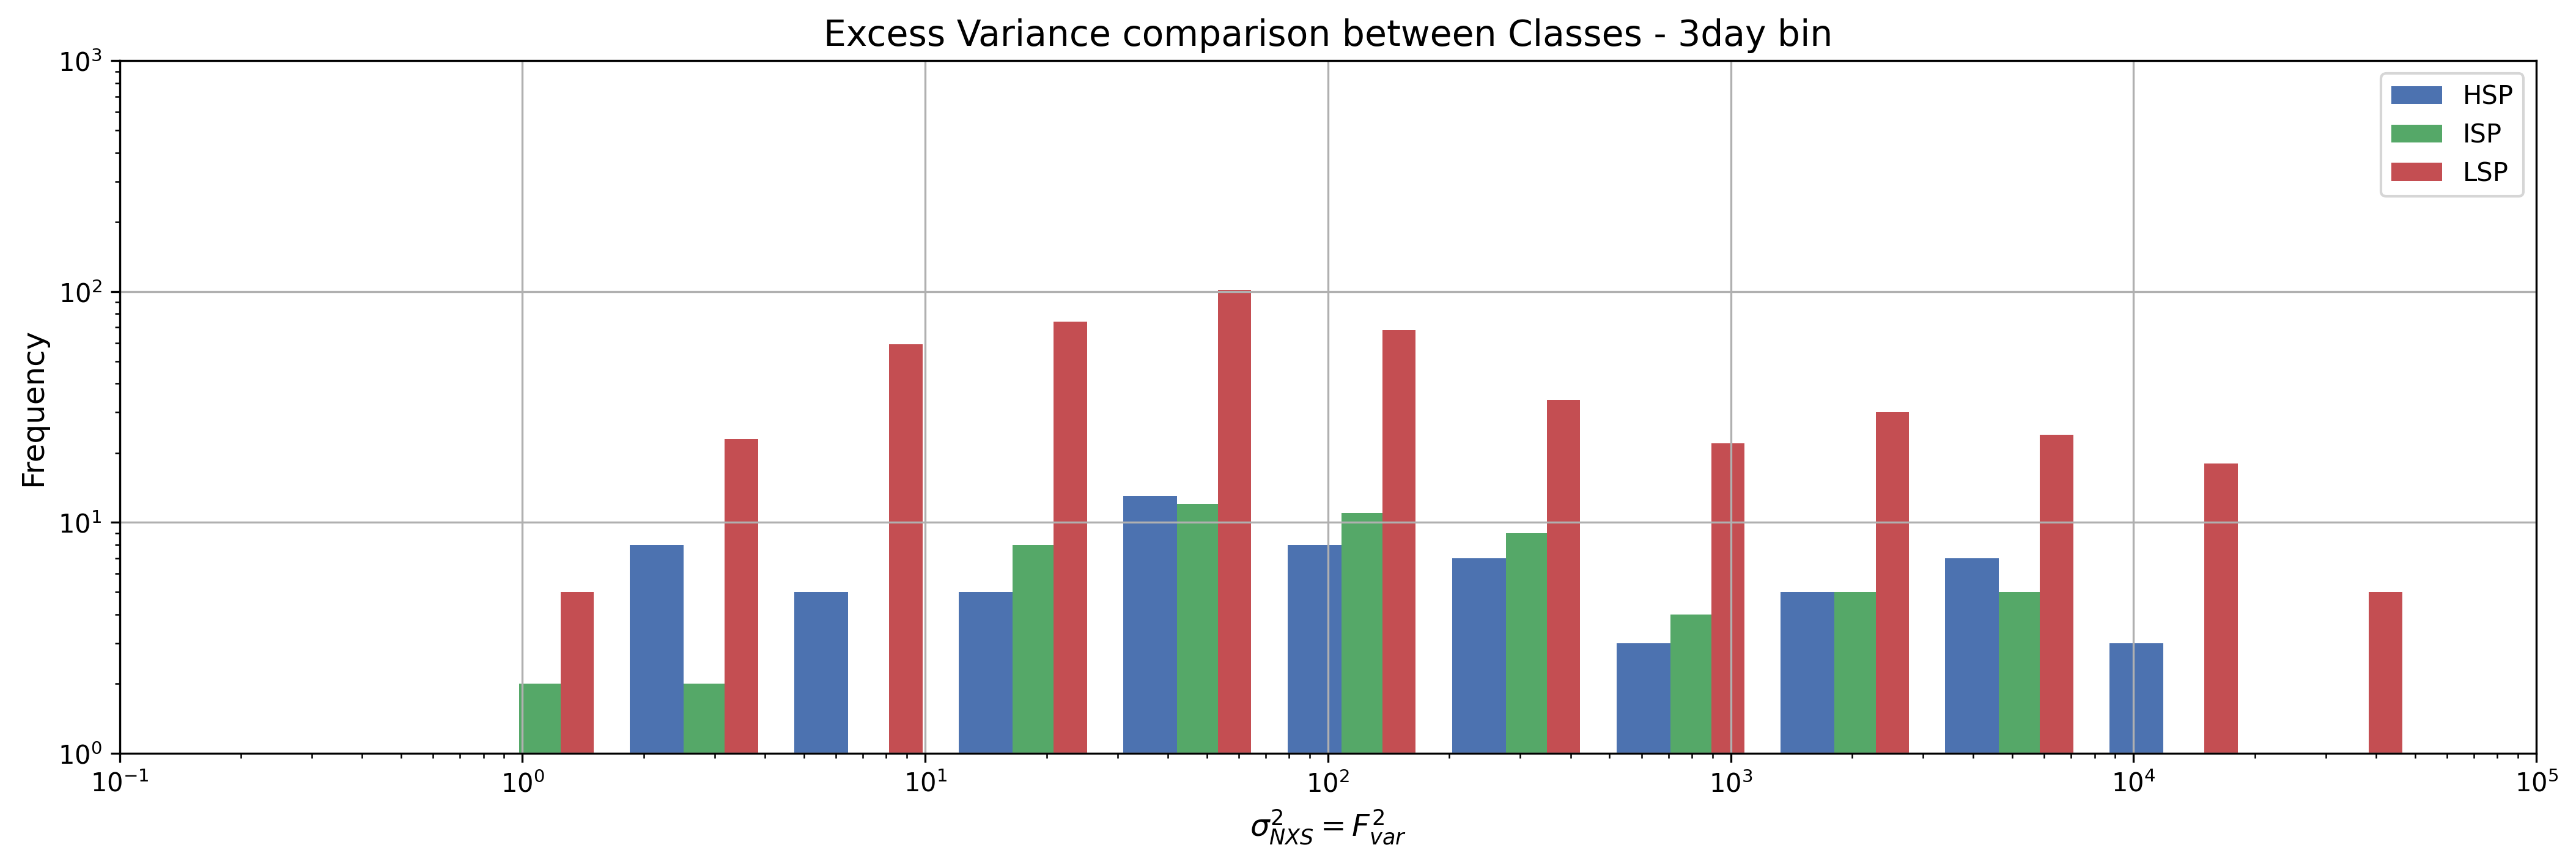

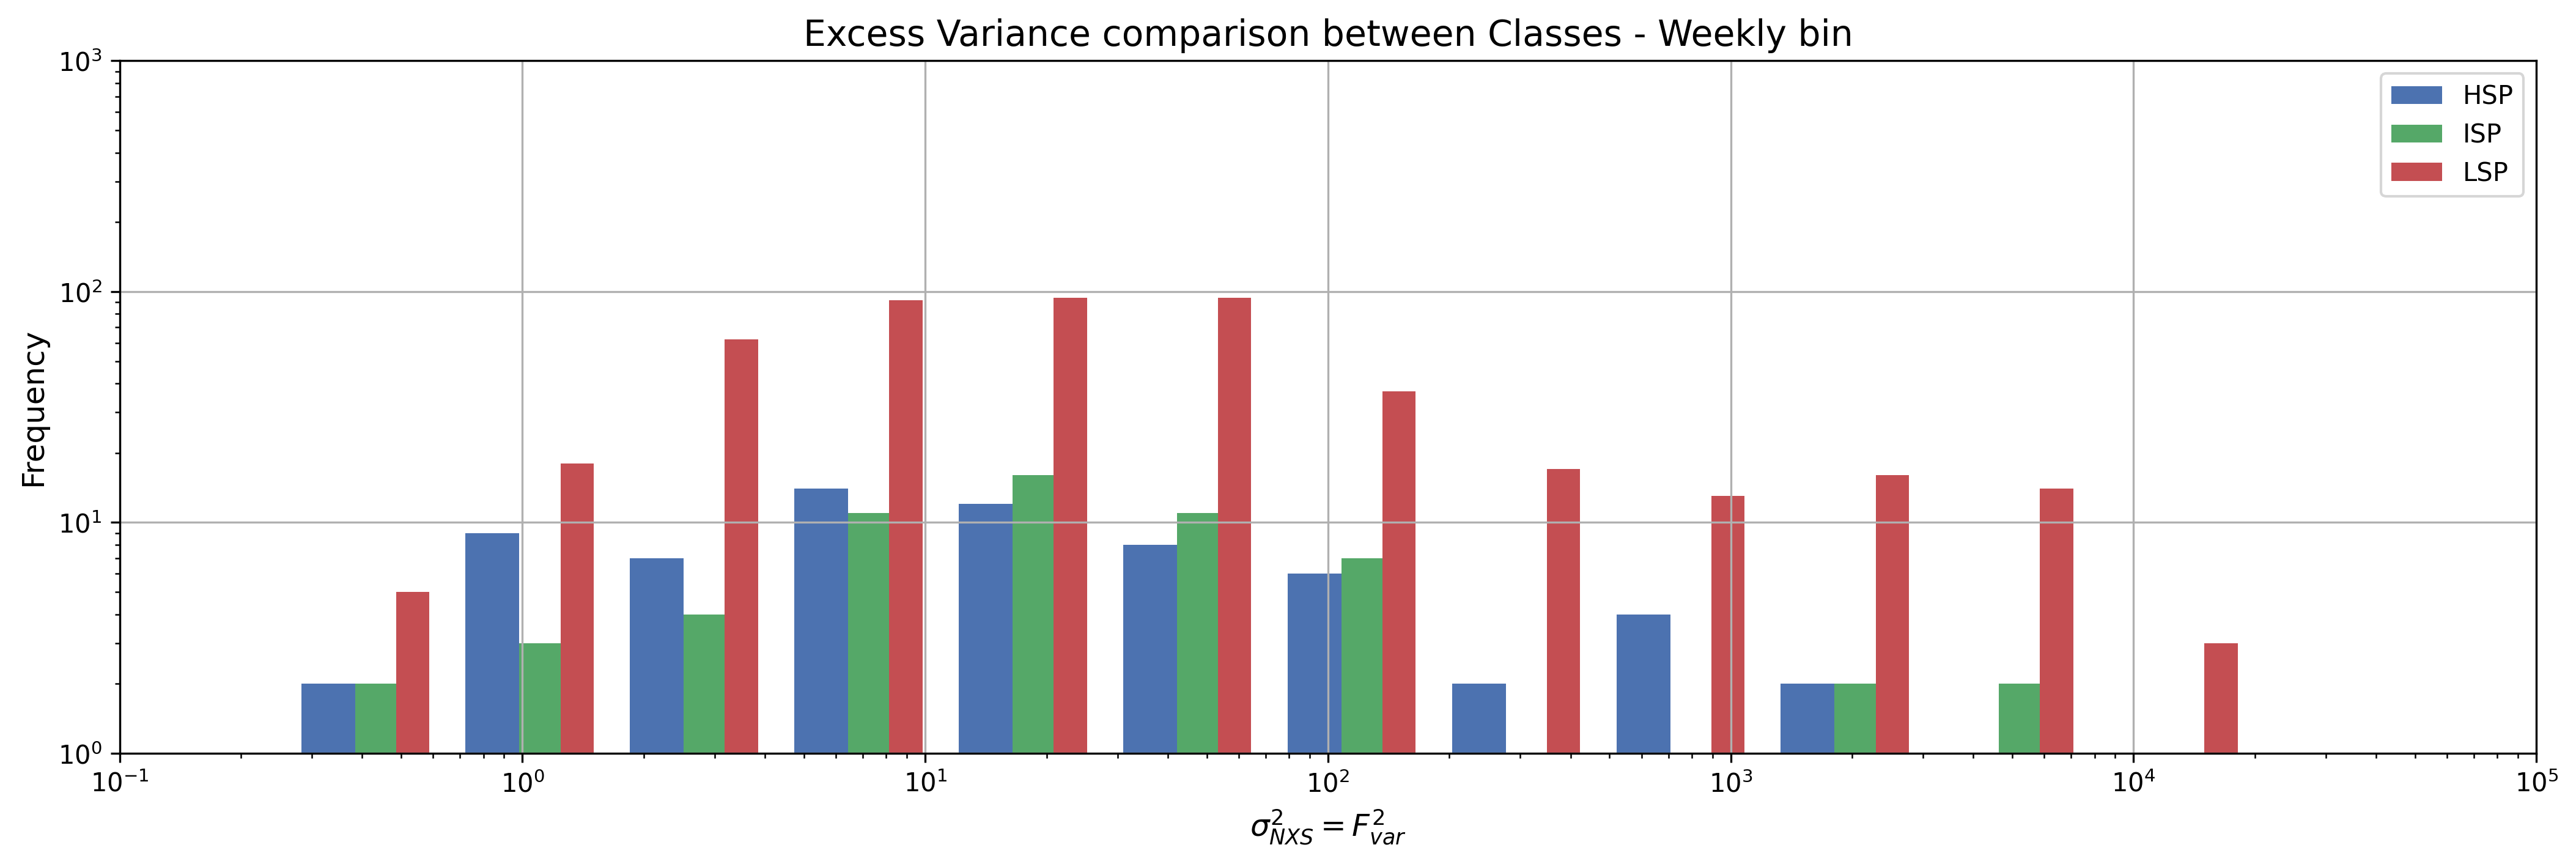

In [97]:
plt.style.use('seaborn-deep')
bins = np.logspace(-10, 10, 50)



## 3 days
plt.figure(figsize=(17,5), dpi=300)

plt.hist([excessvariance_HSP_3days, excessvariance_ISP_3days, excessvariance_LSP_3days], bins, label=['HSP', 'ISP', 'LSP'])
plt.legend(loc='upper right')

plt.title('Excess Variance comparison between Classes - 3day bin', fontsize=14)
plt.xlabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xlim(1e-1,1e5)
plt.ylim(1,1e3)

plt.xscale('log')
plt.yscale('log')

plt.grid(True)
plt.show()





## Weekly
plt.style.use('seaborn-deep')

plt.figure(figsize=(17,5), dpi=300)

plt.hist([excessvariance_HSP_weekly, excessvariance_ISP_weekly, excessvariance_LSP_weekly], bins, label=['HSP', 'ISP', 'LSP'])
plt.legend(loc='upper right')

plt.title('Excess Variance comparison between Classes - Weekly bin', fontsize=14)
plt.xlabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xlim(1e-1,1e5)
plt.ylim(1,1e3)

plt.xscale('log')
plt.yscale('log')

plt.grid(True)
plt.show()

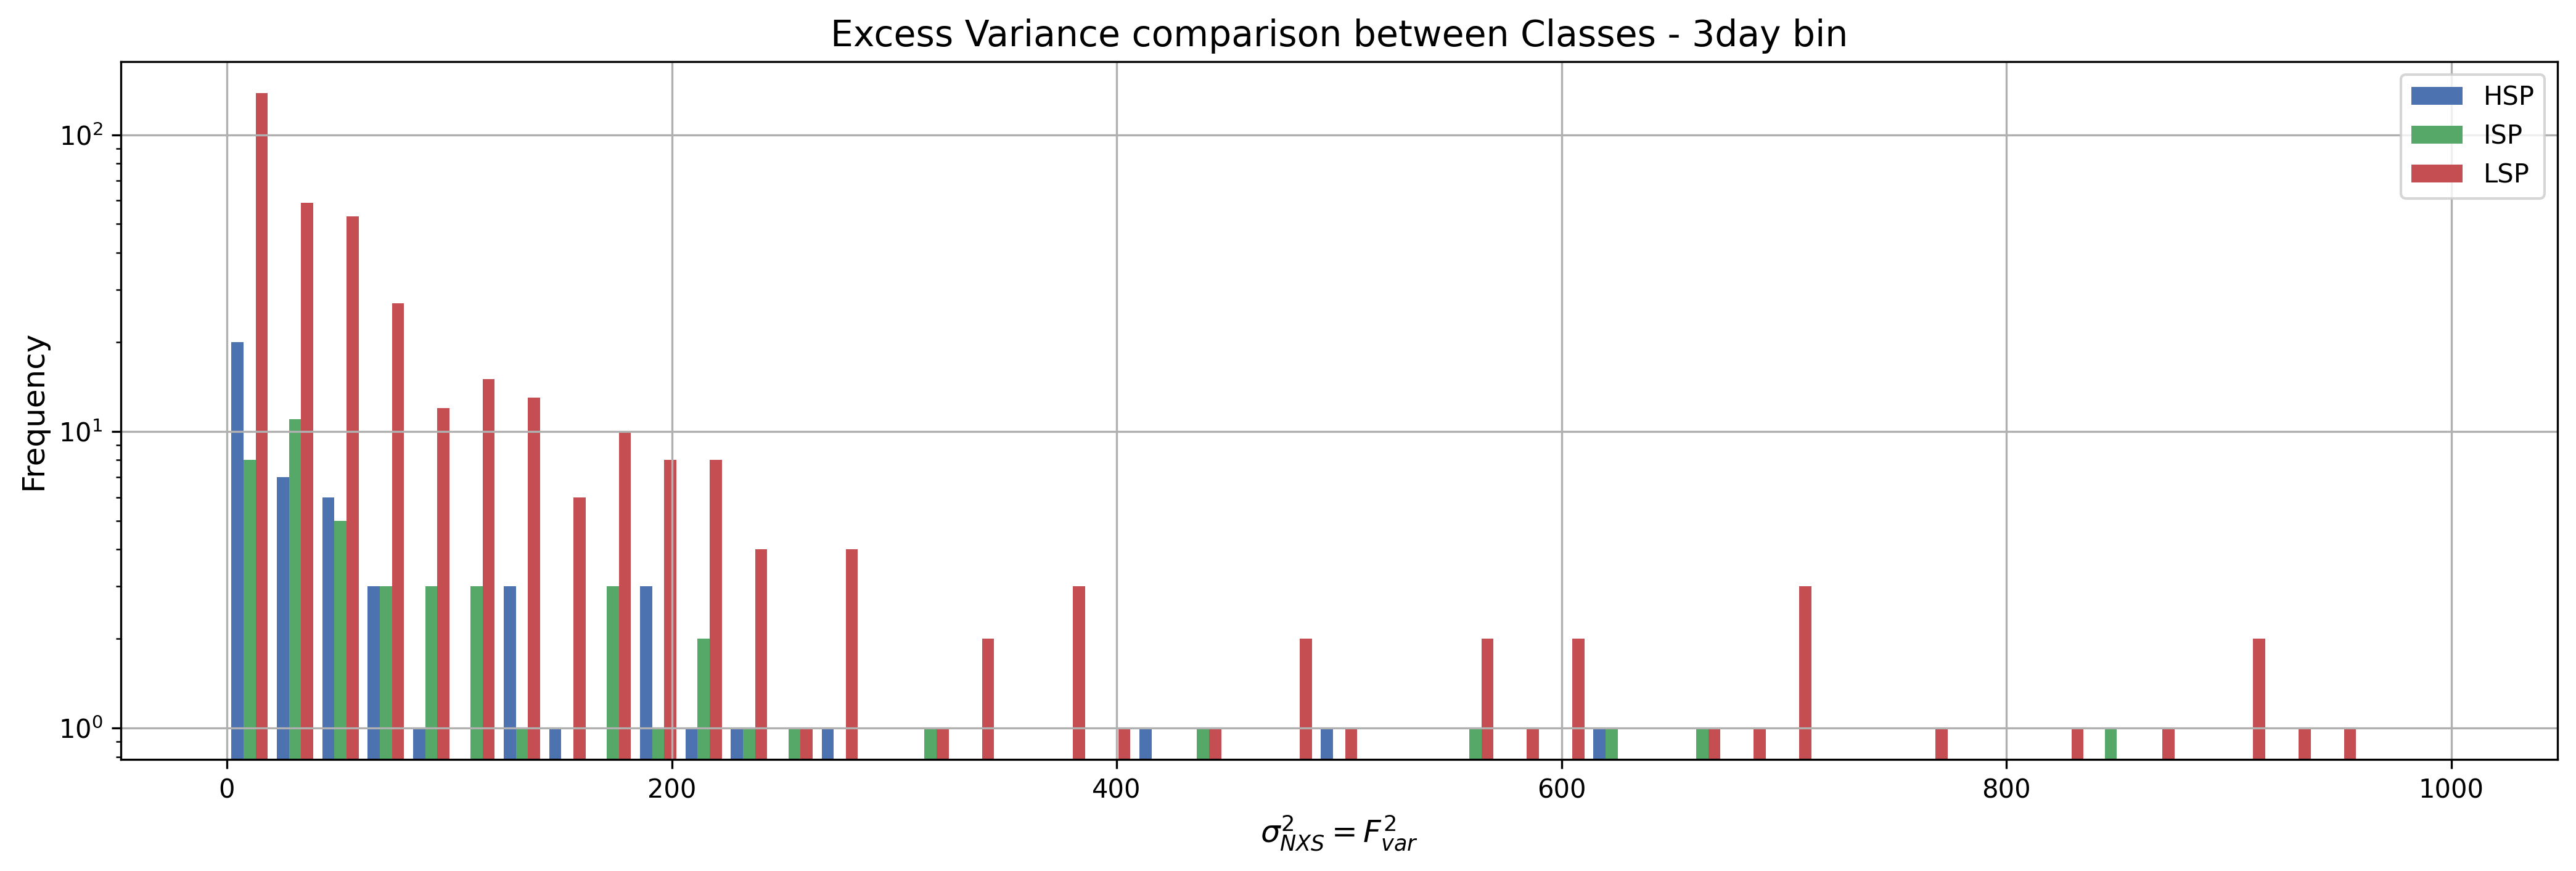

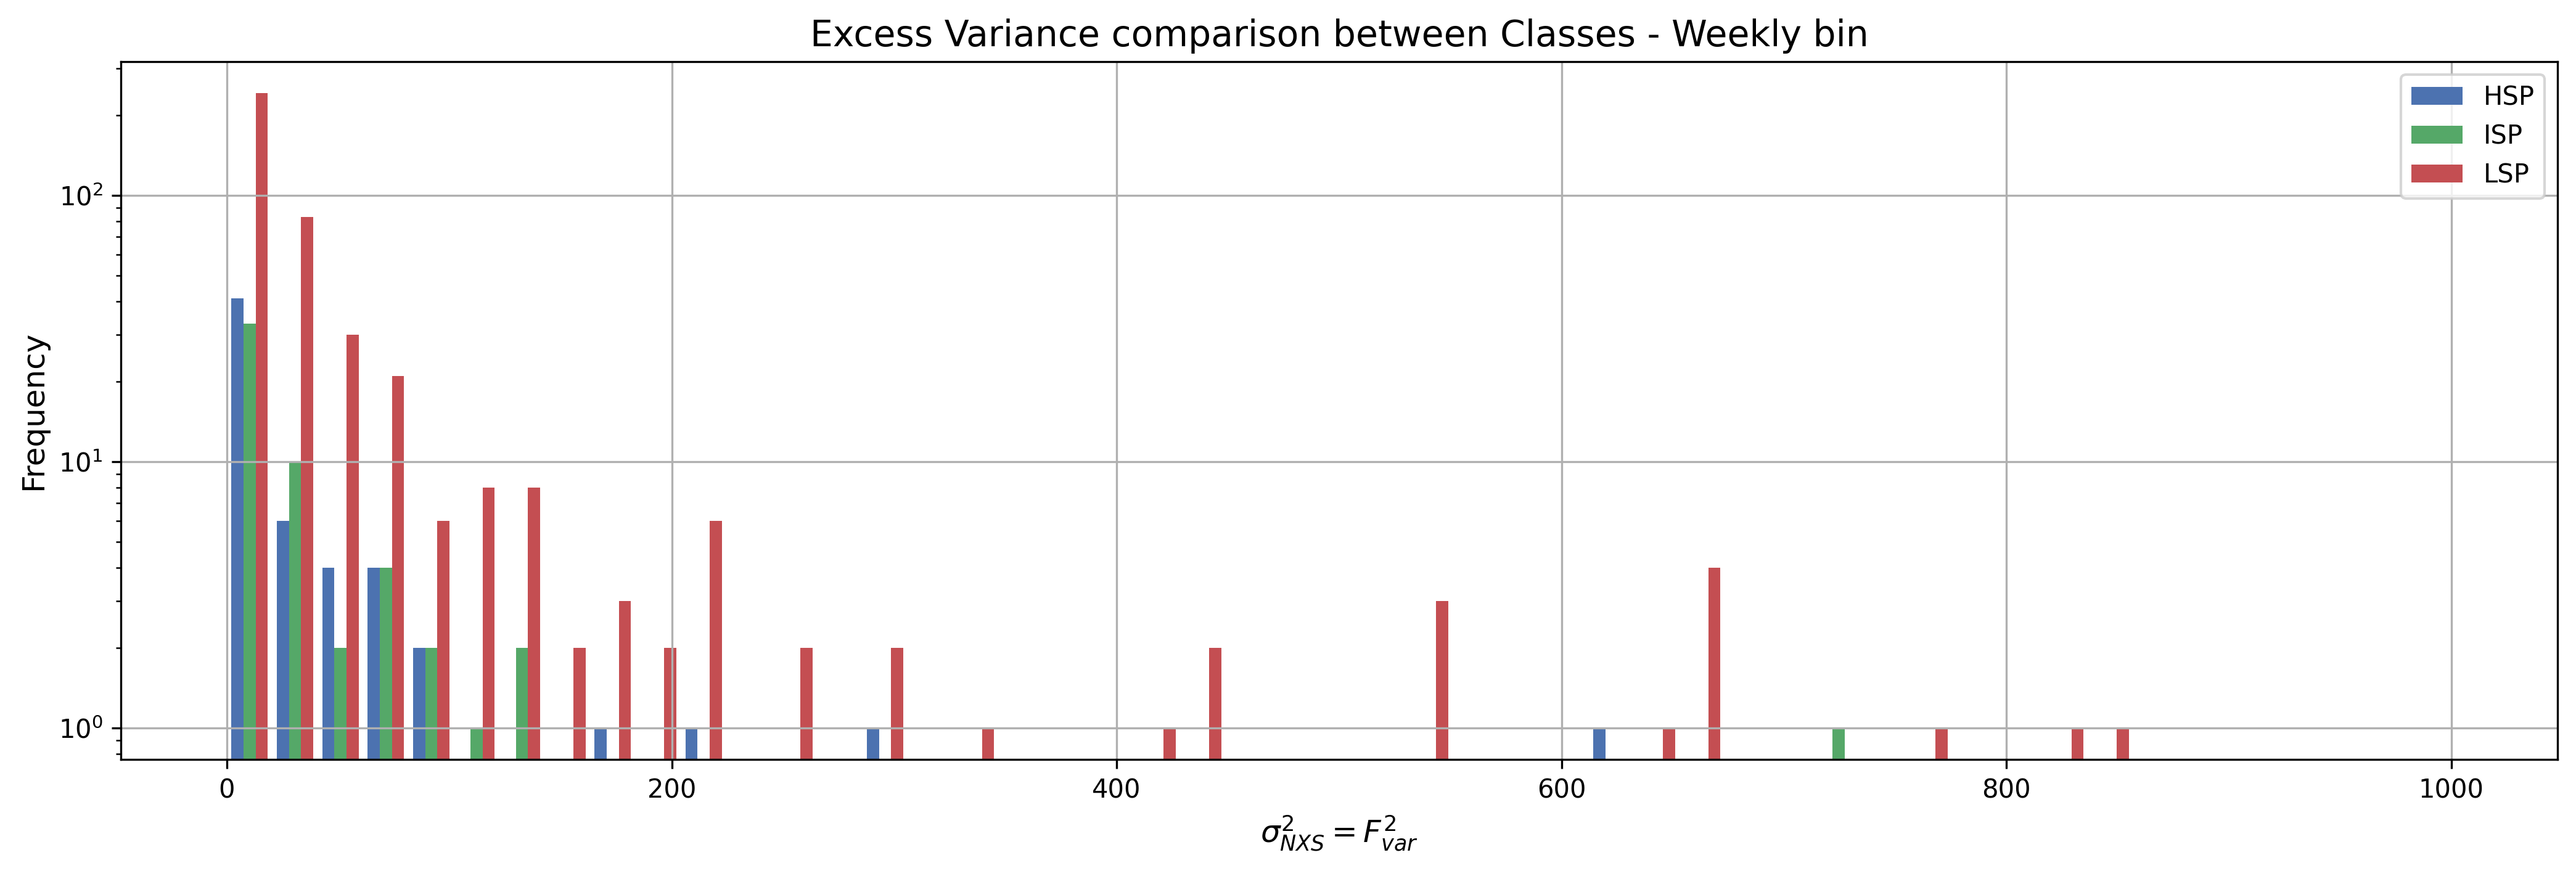

In [92]:
plt.style.use('seaborn-deep')
bins = np.linspace(0, 1000, 50)



## 3 days
plt.figure(figsize=(17,5), dpi=300)

plt.hist([excessvariance_HSP_3days, excessvariance_ISP_3days, excessvariance_LSP_3days], bins, label=['HSP', 'ISP', 'LSP'])
plt.legend(loc='upper right')

plt.title('Excess Variance comparison between Classes - 3day bin', fontsize=14)
plt.xlabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.yscale('log')

plt.grid(True)
plt.show()




## Weekly
plt.style.use('seaborn-deep')

plt.figure(figsize=(17,5), dpi=300)

plt.hist([excessvariance_HSP_weekly, excessvariance_ISP_weekly, excessvariance_LSP_weekly], bins, label=['HSP', 'ISP', 'LSP'])
plt.legend(loc='upper right')

plt.title('Excess Variance comparison between Classes - Weekly bin', fontsize=14)
plt.xlabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.yscale('log')

plt.grid(True)
plt.show()

### 3 Synchrotron Classes

Log in x-axis and y-axis

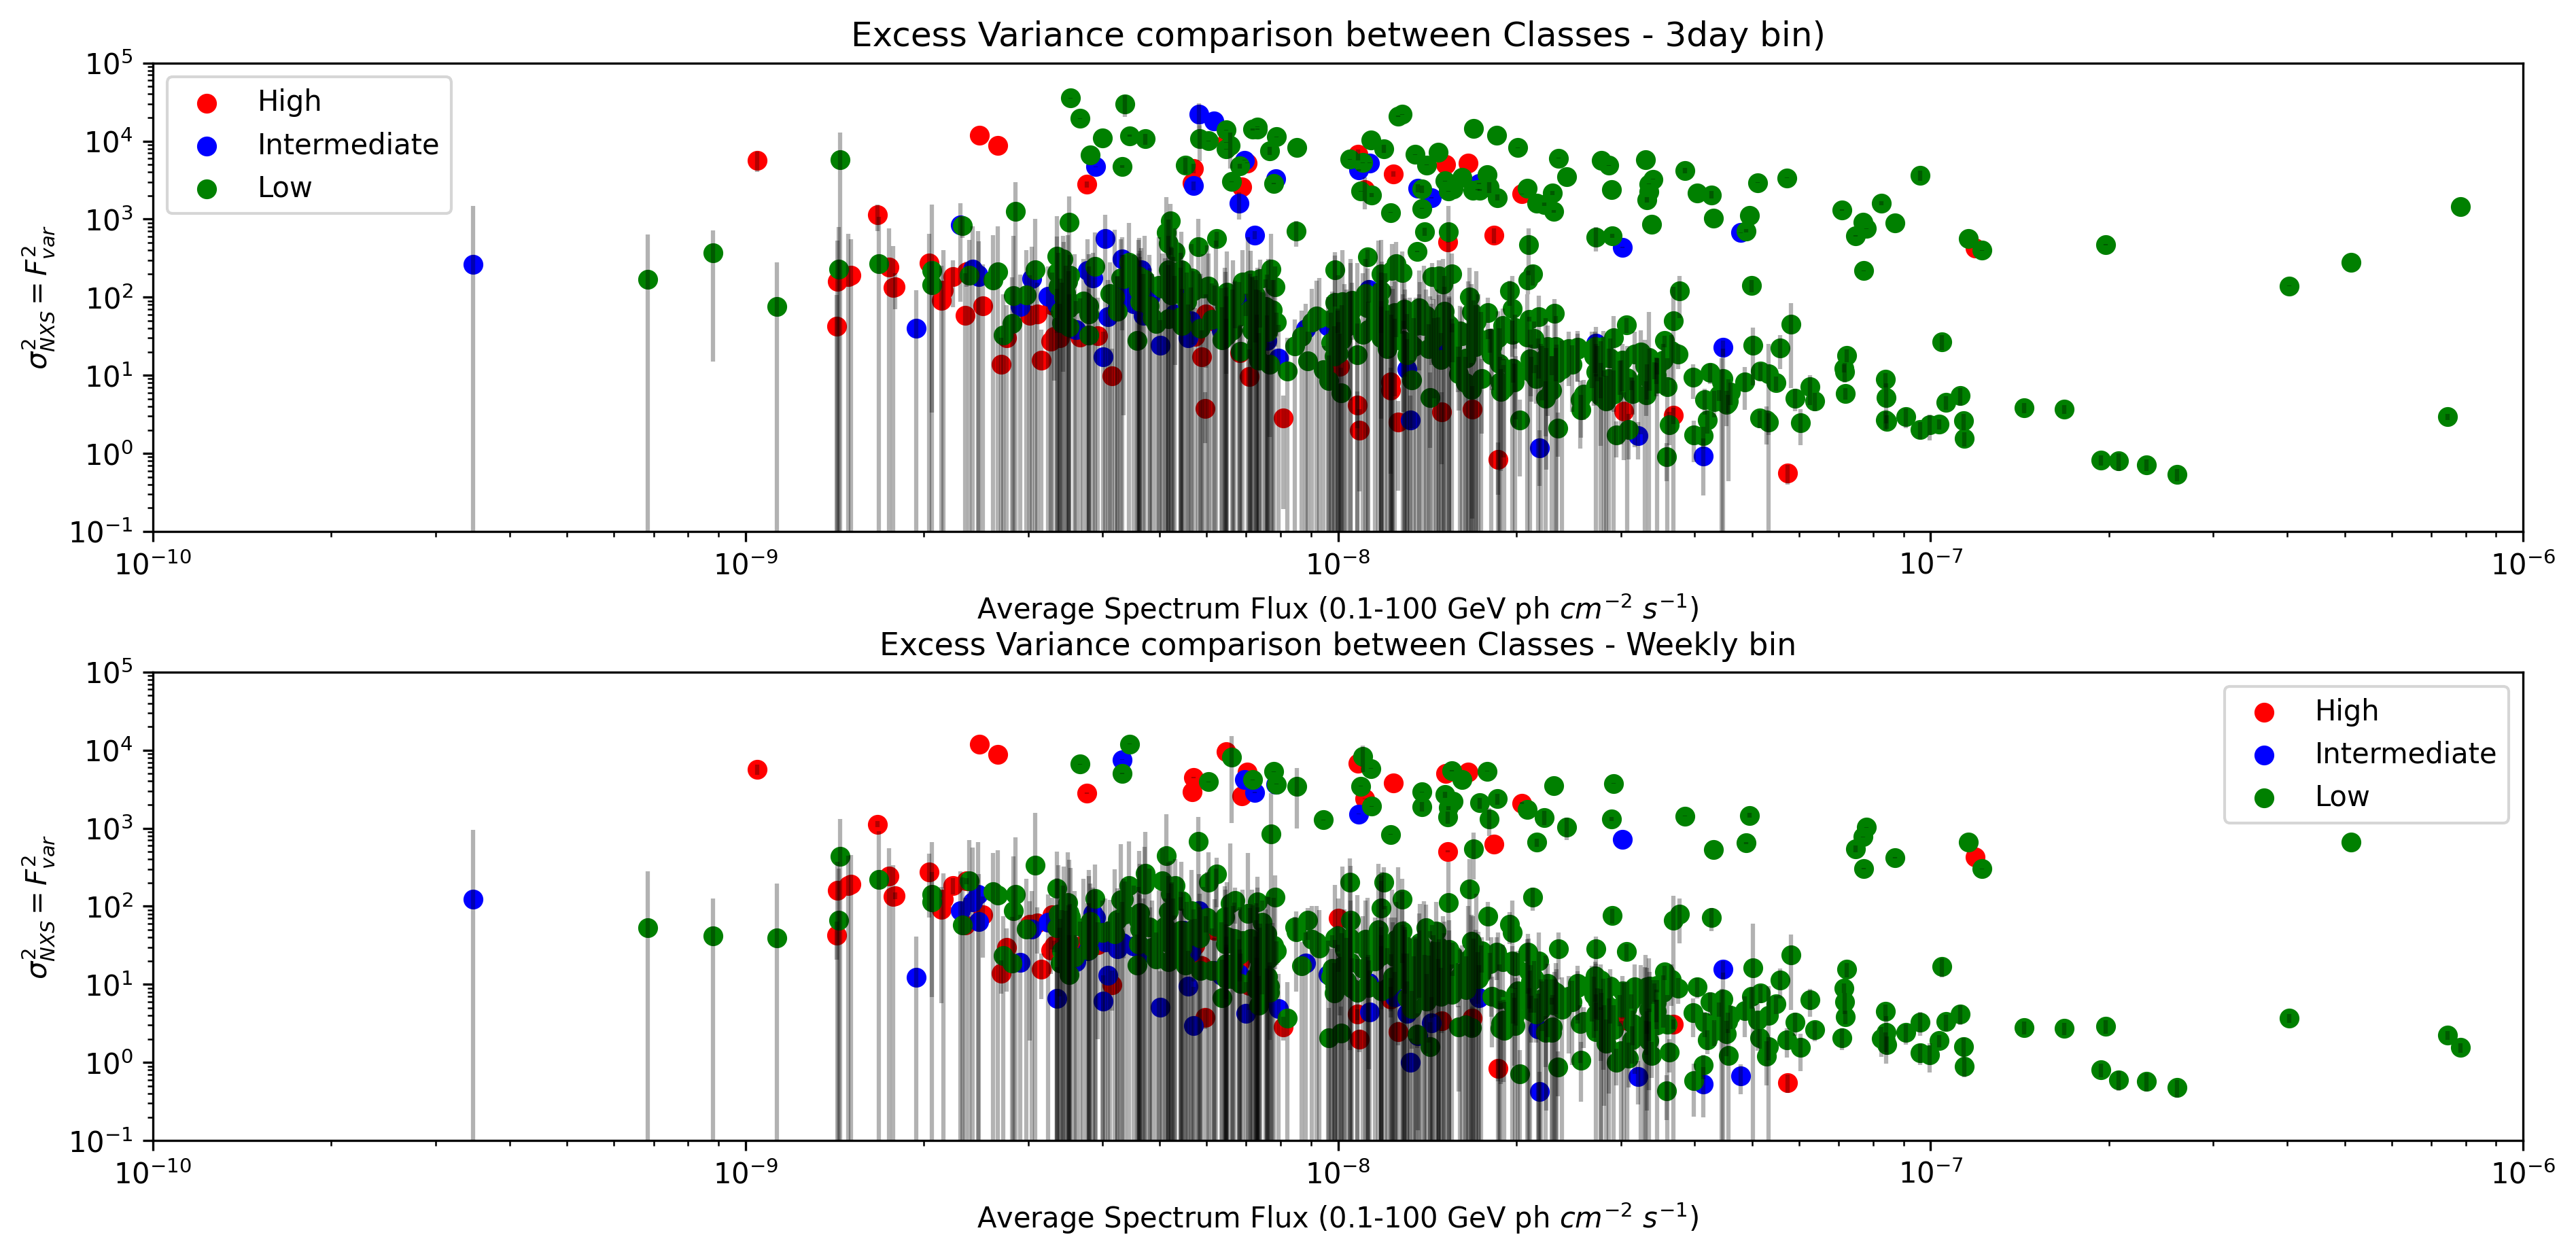

In [74]:
grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.3)

plt.figure(figsize=(15,7), dpi=300)


plt.subplot(grid[0, 0])

## High
plt.scatter(average_spectrumflux_HSP_3days, excessvariance_HSP_3days, color='r', label = 'High')
plt.errorbar(average_spectrumflux_HSP_3days, excessvariance_HSP_3days, 
             yerr = error_excessvariance_HSP_3days, xerr = None, ls='none', ecolor = 'black', alpha = 0.3) 

## Intermediate
plt.scatter(average_spectrumflux_ISP_3days, excessvariance_ISP_3days, color='b', label = 'Intermediate')
plt.errorbar(average_spectrumflux_ISP_3days, excessvariance_ISP_3days, 
             yerr = error_excessvariance_ISP_3days, xerr = None, ls='none', ecolor = 'black', alpha = 0.3)

## Low
plt.scatter(average_spectrumflux_LSP_3days, excessvariance_LSP_3days, color='g', label = 'Low')
plt.errorbar(average_spectrumflux_LSP_3days, excessvariance_LSP_3days, 
             yerr = error_excessvariance_LSP_3days, xerr = None, ls='none', ecolor = 'black', alpha = 0.3) 

plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=10)
plt.title('Excess Variance comparison between Classes - 3day bin)', fontsize=12)
plt.xlim(1e-10,1e-6)
plt.ylim(0.1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()






plt.subplot(grid[1, 0])

## High
plt.scatter(average_spectrumflux_HSP_weekly, excessvariance_HSP_3days, color='r', label = 'High')
plt.errorbar(average_spectrumflux_HSP_weekly, excessvariance_HSP_3days, 
             yerr = error_excessvariance_HSP_weekly, xerr = None, ls='none', ecolor = 'black', alpha = 0.3) 

## Intermediate
plt.scatter(average_spectrumflux_ISP_3days, excessvariance_ISP_weekly, color='b', label = 'Intermediate')
plt.errorbar(average_spectrumflux_ISP_3days, excessvariance_ISP_weekly, 
             yerr = error_excessvariance_ISP_weekly, xerr = None, ls='none', ecolor = 'black', alpha = 0.3)

## Low
plt.scatter(average_spectrumflux_LSP_3days, excessvariance_LSP_weekly, color='g', label = 'Low')
plt.errorbar(average_spectrumflux_LSP_3days, excessvariance_LSP_weekly, 
             yerr = error_excessvariance_LSP_weekly, xerr = None, ls='none', ecolor = 'black', alpha = 0.3)

plt.xlabel('Average Spectrum Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=10)
plt.ylabel('$\sigma _{NXS}^{2} = F_{var}^{2}$', fontsize=10)
plt.title('Excess Variance comparison between Classes - Weekly bin', fontsize=11)
plt.xlim(1e-10,1e-6)
plt.ylim(0.1,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()


plt.show()

## Flux vs index of sources with high Fvar²

In order to prove that the assumptions we make below 10 GeV (softer when brighter) is true/consistent with LAT data.